# Deep Neural Network for Beer Crown Defects Classification

This model is generated based on CS230 course program assignment. The goal is to build a tensorflow model that can classify beer crown based on their differences: color, text, date code, and defects such as crimp flare, and scratches. It considers each pixel as individual feature, which works well with manipulated images from industrial production line, i.e. the images are standardized, similar to each other, with fixed ROI, consistent brightness, color and contrast. 

The model is *LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX*. 
The SIGMOID output layer has been converted to a SOFTMAX for more than two classes. 


The training is based on the following loss function:
$$loss = \mathcal{L}(\hat{y}, y) = (\hat y^{(i)} - y^{(i)})^2 \tag{1}$$

Tensorflow function `tf.nn.sigmoid_cross_entropy_with_logits` is called to calculate the following cross entropy loss: 
$$ J = - \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log a^{ [2] (i)} + (1-y^{(i)})\log (1-a^{ [2] (i)} )\large )\small\tag{2}$$

The procedure:
    1. Create placeholders
    2. Specify the computation graph corresponding to operations you want to compute
    3. Create the session
    4. Run the session, using a feed dictionary if necessary to specify placeholder variables' values.

The model training includes the following items: 
    1. Hyper parameter optimization; 
    2. Number of layers test; 
    3. Training time and Run time test; 
    4. Test the minimum amount of images needed for a good model; 
    5. Test the minimum amount of sample bottles needed for a good model; 
    6. Test the minimum resolution of image needed for a good training. 


In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
#from tf_utils1 import load_dataset, random_mini_batches, convert_to_one_hot, predict
import os.path

%matplotlib inline
np.random.seed(1)


# 1. Load Datasets

- **Training set**: 2400 pictures (240 by 240 pixels) of crowns representing numbers from 0 to 5 (400 pictures per each class).
- **Test set**: 600 pictures (240 by 240 pixels) of crowns representing numbers from 0 to 5 (100 pictures per each class).

Below are examples for each class, and how to represent them. 
<img src="images/crowns.png" style="width:800px;height:442px;"><caption><center> <u><font color='purple'> **Figure 1**</u><font color='purple'>: CROWNS dataset <br> <font color='black'> </center>


Run the following code to load the dataset.

In [2]:
#import h5py
#import numpy as np
#import tensorflow as tf
#import math


# DIR = datasets       #training 2400 + test 600, 240x240x3
# DIR = datasets_mini  #training 120  + test 60,  240x240x3
# DIR = 'datasets_120'   #training 2400 + test 600, 120x120x3
# DIR = datasetsAug   #training 2400 + test 600, 120x120x3

def load_dataset():
    #train_dataset = h5py.File(os.path.join(DIR, '/train_crown.h5'), "r")
    train_dataset    = h5py.File('datasets_Aug/train_crown.h5', "r")
    train_set_x_orig = np.array(train_dataset["X"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["y"][:]) # your train set labels

    #test_dataset = h5py.File(os.path.join(DIR, '/test_crown.h5'), "r")
    test_dataset    = h5py.File('datasets_Aug/test_crown.h5', "r")
    test_set_x_orig = np.array(test_dataset["X"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["y"][:]) # your test set labels

    # classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    classes = np.array([0,1,2,3,4,5])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    #x = tf.placeholder("float", [172800, 1])
    x = tf.placeholder("float", [43200, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3
    

In [3]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Change the index below and run the cell to visualize some examples in the dataset.

y = 2


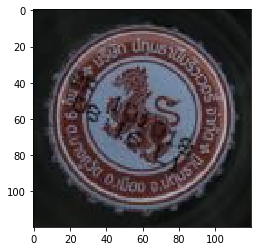

In [4]:
# TO chck if image feature is created and loaded properly, display one image based on its index
# If there is color difference, then most likely there is mistake in Create_datasets.
index = 8
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

Flatten the image dataset, then normalize it by dividing by 255. Convert each label to a one-hot vector.

In [5]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

#print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of test examples = 600
X_train shape: (43200, 2400)
Y_train shape: (6, 2400)
X_test shape: (43200, 600)
Y_test shape: (6, 600)


# 2. Create Placeholders

Create placeholders for `X` and `Y`. This will allow to later pass the training data in when run the session. 

In [6]:
# Create placeholders in Tensorflow

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 240 * 240 * 3 = 172800 or 120 * 120 * 3 = 43200)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32, shape=[n_x, None], name="X")
    Y = tf.placeholder(tf.float32, shape=[n_y, None], name="Y")
    
    return X, Y

In [7]:
#X, Y = create_placeholders(172800, 6)
X, Y = create_placeholders(43200, 6)

#print ("X = " + str(X))
#print ("Y = " + str(Y))

# 3. Initializing the parameters

Use Xavier Initialization for weights and Zero Initialization for biases. Xavier initialization, Kaiming initialization. 

In [8]:
INITIALIZER = "Xavier"
#INITIALIZER = "He"

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1) 
    
    # Xavier initialization
    if INITIALIZER == "Xavier": 
        #W1 = tf.get_variable("W1", [25,172800], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        W1 = tf.get_variable("W1", [25,43200], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
        W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
        W3 = tf.get_variable("W3", [6,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        b3 = tf.get_variable("b3", [6,1], initializer = tf.zeros_initializer())

    # Kaiming initialization  initializer=tf.contrib.layers.variance_scaling_initializer())
    if INITIALIZER == "He":
        #W1 = tf.get_variable("W1", [25,172800], initializer = tf.contrib.layers.variance_scaling_initializer(seed = 1))
        W1 = tf.get_variable("W1", [25,43200], initializer = tf.contrib.layers.variance_scaling_initializer(seed = 1))
        b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
        W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.variance_scaling_initializer(seed = 1))
        b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
        W3 = tf.get_variable("W3", [6,12], initializer = tf.contrib.layers.variance_scaling_initializer(seed = 1))
        b3 = tf.get_variable("b3", [6,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [9]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    #print("W1 = " + str(parameters["W1"]))
    #print("b1 = " + str(parameters["b1"]))
    #print("W2 = " + str(parameters["W2"]))
    #print("b2 = " + str(parameters["b2"]))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# 4. Forward propagation in tensorflow 

Implement the forward propagation module in tensorflow. The function will take in a dictionary of parameters and it will complete the forward pass.  

**Question:** Implement the forward pass of the neural network. We commented for you the numpy equivalents so that you can compare the tensorflow implementation to numpy. It is important to note that the forward propagation stops at `z3`. The reason is that in tensorflow the last linear layer output is given as input to the function computing the loss. Therefore, you don't need `a3`!



In [10]:

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)                    # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                  # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                   # Z2 = np.dot(W2, A1) + b2
    A2 = tf.nn.relu(Z2)                                  # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                   # Z3 = np.dot(W3, A2) + b3
    
    return Z3

In [11]:
tf.reset_default_graph()

with tf.Session() as sess:
    #X, Y = create_placeholders(172800, 6)
    X, Y = create_placeholders(43200, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    #print("Z3 = " + str(Z3))

The forward propagation doesn't output any cache. You will understand why below, when we get to brackpropagation.

# 5. Compute cost

Simply call reduce mean apply to cross entroy loss fucntion.
```python
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))
```

In [12]:

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits =logits, labels =labels))
    
    return cost

In [13]:
tf.reset_default_graph()

with tf.Session() as sess:
    #X, Y = create_placeholders(172800, 6)
    X, Y = create_placeholders(43200, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    #print("cost = " + str(cost))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# 6. Backward propagation & parameter updates

This is where you become grateful to programming frameworks. All the backpropagation and the parameters update is taken care of in 1 line of code. It is very easy to incorporate this line in the model.

Create an "`optimizer`" object. Call this object along with the cost when running the tf.session. When called, it will perform an optimization on the given cost with the chosen method and learning rate.

This computes the backpropagation by passing through the tensorflow graph in the reverse order. From cost to inputs.


# 7. Building the model

Use Adam optimizer. Tested with Gradient Descent Optimizer.
User learning_rate, and minibatch_size and num_epochs to control performance and total training time. 

In [14]:
# global variables
LEARNING_RATE  = 0.0001  # 0.0001, 0.001, 0.0005, 0.0002
NUM_EPOCHS     = 40      # 100, 200, 80, 40, 20
MINIBATCH_SIZE = 32      # 64 #16  #8


def model(X_train, Y_train, X_test, Y_test, learning_rate = LEARNING_RATE,
          num_epochs = NUM_EPOCHS, minibatch_size = MINIBATCH_SIZE, print_cost = True, print_accuracy = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch %100 % 5
            if print_cost == True and epoch % 2 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 2 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per twos)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters



Run the model and return parameters trained. This parameters will be saved for the future prediction actions.

Cost after epoch 0: 3.382383
Cost after epoch 2: 2.261131
Cost after epoch 4: 1.478126
Cost after epoch 6: 0.940076
Cost after epoch 8: 0.442730
Cost after epoch 10: 0.224838
Cost after epoch 12: 0.136960
Cost after epoch 14: 0.092203
Cost after epoch 16: 0.065505
Cost after epoch 18: 0.048583
Cost after epoch 20: 0.037545
Cost after epoch 22: 0.029401
Cost after epoch 24: 0.023340
Cost after epoch 26: 0.018930
Cost after epoch 28: 0.015491
Cost after epoch 30: 0.012895
Cost after epoch 32: 0.010783
Cost after epoch 34: 0.009161
Cost after epoch 36: 0.007754
Cost after epoch 38: 0.006680


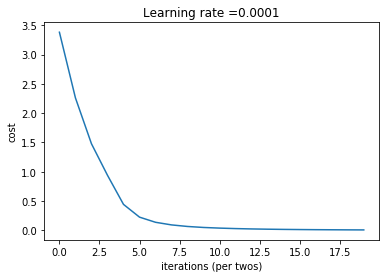

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 1.0
Run time = 31.38234513392672s


In [25]:

import time
tic = time.perf_counter()

parameters = model(X_train, Y_train, X_test, Y_test)

toc = time.perf_counter()
print("Run time = " + str(toc-tic) +"s")

# 8. Evaluate with images 

The images shall be different from those images in the train set and test set.
    - For crowns with different color or text, the evaluation images are the same except orientation.
    - For crimp flare and scratch defects, there are size, shape, position, and orientation difference.
    - Create adversarial images for test.


In [16]:
def className(i):
    if pridectClassNumber == 0:
        predictClassName   = "  Good crown";
    if pridectClassNumber == 1:
        predictClassName   = "  Crown with color difference";
    if pridectClassNumber == 2:
        predictClassName   = "  Crown with date code";
    if pridectClassNumber == 3:
        predictClassName   = "  Crown with crimp flare";
    if pridectClassNumber == 4:
        predictClassName   = "  Crown with different text";
    if pridectClassNumber == 5:
        predictClassName   = "  Crown with scratch";
    return predictClassName

Predict Run Time: 48ms
Predict Results : y = 5  Crown with scratch


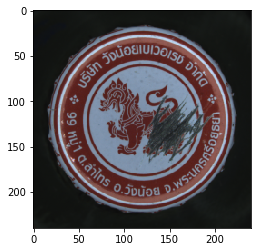

In [45]:
import scipy
import scipy.misc
from PIL import Image
from scipy import ndimage
import time
import warnings
warnings.filterwarnings('ignore')

# Evaluate with images
#my_image = "good.jpg"     # classID=0
#my_image = "color.jpg"    # classID=1
#my_image = "date.jpg"     # classID=2
#my_image = "flare.jpg"    # classID=3
#my_image = "text.jpg"     # classID=4
#my_image = "scratch.jpg"  # classID=5
#my_image = "0.bmp"        # classID=3 
my_image = "40.bmp"       # classID=5 

fname = "images/" + my_image

tic = time.perf_counter()
image = np.array(plt.imread(fname, format=None))
# normalization
image = image/255.

my_image = scipy.misc.imresize(image, size=(120,120)).reshape((1, 120*120*3)).T

my_image_prediction = predict(my_image, parameters)
toc = time.perf_counter()
print("Predict Run Time: " + str(round((toc-tic)*1000.)) +"ms")

pridectClassNumber = np.squeeze(my_image_prediction)
predictClassName   = className(pridectClassNumber)

plt.imshow(image)
print("Predict Results : y = " + str(np.squeeze(my_image_prediction)) + predictClassName)

The End.